#### Initialisation (have to run it every time)

In [ ]:
# data parsing and working with dataset
# !pip install beautifulsoup4 
# !pip install requests
# !pip install transformers
# !pip install pandas

!pip install openpyxl --upgrade --ignore-installed openpyxl
from bs4 import BeautifulSoup
import requests as rq
import pandas as pd
import numpy as np
from google.colab import drive
import torch

# import zipfile

# for text preprocessing
import re
from IPython.core.display import clear_output

# for formatting
from datetime import datetime, timedelta

# for visualization
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

     |████████████████████████████████| 242 kB 4.1 MB/s 


In [ ]:
# Import Google Drive
drive.mount('/content/drive')
%cd '/content/drive/MyDrive/HSE/Project 2021'

# !unzip /content/drive/MyDrive/ML_IAD/iad-deep-learning-texts-2021.zip
# press_releases = pd.read_excel('cbr.xlsx')

Mounted at /content/drive
/content/drive/MyDrive/HSE/Project 2021


In [ ]:
# Additional functions

def delete_multiple_element(list_object, indices):
    '''
    delete multiple objects with certain indeces from the list
    from https://thispointer.com/python-remove-elements-from-list-by-index/#4
    '''
    indices = sorted(indices, reverse=True)
    for idx in indices:
        if idx < len(list_object):
            list_object.pop(idx)


def get_date(date, df=True, file_type=''):
    '''
    Tranform date from the cbr.ru into date format
    '''
    if df==True:
        month_list = ['января', 'февраля', 'марта', 'апреля', 'мая', 'июня', 'июля', 'августа', 'сентября', 'октября', 'ноября', 'декабря']
        date_list = date.split()
        if file_type == 'Пресс-релиз':
            return datetime(int(date_list[2]), month_list.index(date_list[1])+1, int(date_list[0]), 13, 30)
        elif file_type == 'Пресс-конференция':
            return datetime(int(date_list[2]), month_list.index(date_list[1])+1, int(date_list[0]), 15, 00)
        else:
            return datetime(int(date_list[2]), month_list.index(date_list[1])+1, int(date_list[0]), 10, 00) # the time does not matter for other types of documents - it is only important to get the news before the publication
    else:
        date_list = str(date).split()[0].split('-')
        return (str(date_list[2]) + '.' + 
                str(date_list[1]) + '.' + 
                str(date_list[0])) # dd.mm.yyyy

def get_date_and_time(date, time):
    month_list = ['января', 'февраля', 'марта', 'апреля', 'мая', 'июня', 'июля', 'августа', 'сентября', 'октября', 'ноября', 'декабря']
    date_list = date.split()
    time_list = time.split(':')
    return datetime(int(date_list[2]), month_list.index(date_list[1])+1, int(date_list[0]), int(time_list[0]), int(time_list[1]))



def unpack_list(mylist):
    '''
    flatten the list of lists
    '''
    return [x for l in mylist for x in l]




### Scraping Data from the CBR Site

Link: https://cbr.ru/dkp/mp_dec/

The whole set of previews, available: from 03/09/2013 to 17/12/2021. It consists of 68 objects.

In [ ]:
previews = []
for i in range(8):
    url = f'https://cbr.ru/Content/NewsList/LoadMore/84035?offset={i}0'
    soup = BeautifulSoup(rq.get(url).text, "html.parser")
    for day in soup.findAll('div', class_="previews_day"):
        previews.append({
            'date': get_date_and_time(day.find("div", class_="previews_day-date").text, day.find("div", class_="previews_item-time").text),
            'title': day.find('div', class_="previews_item-title").text,  # [item. text for item in day.findAll('div', class_="previews_item-title")]
            'link': 'https://cbr.ru' + str(day.find('a')['href']),
            'text': BeautifulSoup(rq.get('https://cbr.ru' + str(day.find('a')['href'])).text, "html.parser").find('div', class_="landing-text").get_text(separator=' ').strip().replace('\xa0',' ').replace('\n', '').replace('\r', '').replace('\t', '')
        })

previews = pd.DataFrame(previews)
previews['text'][64] = previews['text'][64][previews['text'][64].find('Совет директоров Банка России'):]  # there was a problem with the style of this text
previews = previews.drop(previews.index[[48,51,54,71]]).reset_index(drop=True)

previews.to_excel('cbr_previews.xlsx')
clear_output()
previews.head()

,date,title,link,text
0,2021-12-17 13:30:00,Банк России принял решение повысить ключевую с...,https://cbr.ru/press/pr/?file=17122021_133000K...,Совет директоров Банка России 17 декабря 2021 ...
1,2021-10-22 13:30:00,Банк России принял решение повысить ключевую с...,https://cbr.ru/press/pr/?file=22102021_133000K...,Совет директоров Банка России 22 октября 2021 ...
2,2021-09-10 13:30:00,Банк России принял решение повысить ключевую с...,https://cbr.ru/press/pr/?file=10092021_133000K...,Совет директоров Банка России 10 сентября 2021...
3,2021-07-23 13:30:00,Банк России принял решение повысить ключевую с...,https://cbr.ru/press/pr/?file=23072021_133000K...,Совет директоров Банка России 23 июля 2021 год...
4,2021-06-11 13:30:00,Банк России принял решение повысить ключевую с...,https://cbr.ru/press/pr/?file=11062021_133000K...,Совет директоров Банка России 11 июня 2021 год...


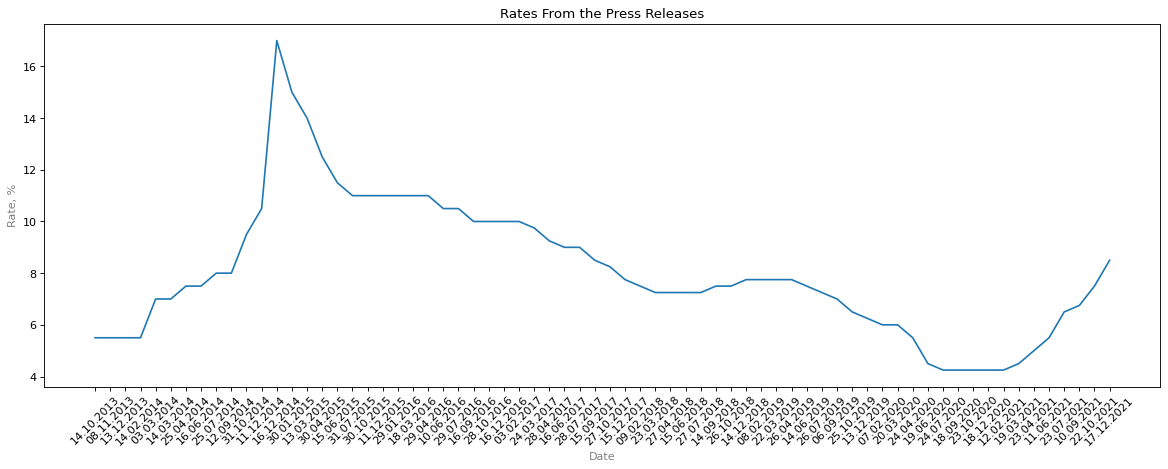

In [ ]:
# previews['rate'] = [previews['text'][i][previews['text'][i].find("годовых")-7:previews['text'][i].find("годовых")-2].strip().replace(',', '.') 
                             for i in range(len(previews['text']))] # the rate, set after the meeting 
# previews['rate'] = [float(re.findall(r'\d*\.\d+|\d+', rate)[0]) for rate in previews['rate']]
# previews['direction'] = [previews['text'][i][previews['text'][i].find("принял решение")+15:previews['text'][i].find("ключевую ставку")-1].strip() 
#                               for i in range(len(previews['text']))] # was it increased or decreased
# clear_output()

plt.figure(figsize=(18, 6), dpi=80)
plt.plot([i.strftime("%d.%m.%Y") for i in previews['date'].iloc[::-1]], previews['rate'].iloc[::-1])
plt.title('Rates From the Press Releases')
plt.xlabel('Date', color='gray')
plt.ylabel('Rate, %',color='gray')
plt.xticks(rotation=45)
plt.show()

### Tokenization and quantitative analysis of CBR previews

In [ ]:
!pip install pymorphy2
import pymorphy2
import nltk
import string
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
russian_stopwords = stopwords.words("russian")
russian_stopwords.extend(['также', 'это'])
morph = pymorphy2.MorphAnalyzer()

clear_output()

def delete_stop_words(text):
    return ' '.join([morph.parse(word)[0].normal_form for word in word_tokenize(text) if word not in russian_stopwords])

In [ ]:
# delete all beginnings and endings because they are the same for almost all statements and do not add meaning to the preview - deleting them would 'enrich' the text, make it more informative

previews['preprocessed'] = [
       delete_stop_words(
           re.sub(r'[^\w\s]+|[\d]+', r'',
                  previews['text'][i][previews['text'][i].find("годовых")+9:previews['text'][i].find("Следующее ")].lower()
                  ).strip() 
       )
      for i in range(len(previews['text']))
      ]

# previews.to_excel('cbr_previews.xlsx')

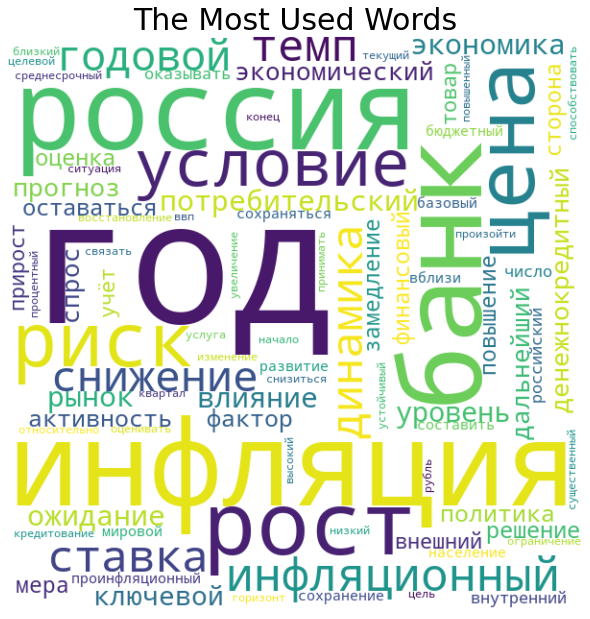

In [ ]:
from wordcloud import WordCloud,STOPWORDS
def wordCloud_generator(data, title=None):
    # https://medium.com/analytics-vidhya/predicting-the-ratings-of-reviews-of-a-hotel-using-machine-learning-bd756e6a9b9b
    wordcloud = WordCloud(width = 600, height = 600,
                          background_color ='white',
                          min_font_size = 10,
                          collocations=False
                         ).generate(" ".join(data))                      
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud, interpolation='bilinear') 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.title(title,fontsize=30)
    plt.show()
wordCloud_generator(previews['preprocessed'], title="The Most Used Words")

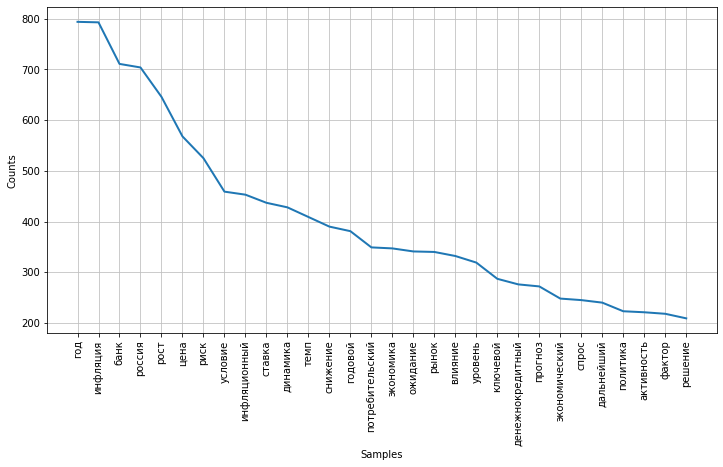

In [ ]:
from nltk.probability import FreqDist
# https://habr.com/ru/post/517410/

cbr_tokens = unpack_list([word_tokenize(release) for release in previews['preprocessed']])
text = nltk.Text(cbr_tokens)
fdist = FreqDist(text)

plt.figure(figsize=(12, 6))
fdist.plot(30,cumulative=False)

In [ ]:
print('Example of a preprocessed text:\n')
previews['preprocessed'][62]

Example of a preprocessed text:



'настоящий время сохраняться существенный инфляционный риск который обусловить повышение ключевой ставка март год нестабильность внешний условие увеличение волатильность финансовый рынок способствовать рост экономический неопределённость данные условие приоритетный задача банк россия являться ограничение инфляционный последствие курсовой динамика поддержание финансовый стабильность связь это банк россия намеренный снижать ключевой ставка близкий месяц восстановление мировой экономика происходить медленно экономический рост большинство страна торговый партнёр россия оставаться слабый ограничивать спрос товар российский экспорт сдерживать рост отечественный экономика вместе цена нефть сохраняться высокий уровень зарубежный инфляция оставаться стабильный оказывать значимый влияние внутренний цена темп рост российский экономика попрежний замедляться продолжаться стагнация промышленный производство инвестиционный активность оставаться низкий условие экономический неопределённость снижение п